In [152]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import sklearn.utils

import plotting

In [176]:
def prepocess(X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    assert X.ndim == 2
    assert y.ndim <= 2

    return (
        StandardScaler().fit_transform(X),
        StandardScaler().fit_transform(y.reshape(-1, 1)).reshape(y.shape),
    )


def linear_projection_sensitivity(X: np.ndarray, y: np.ndarray, r2_scaled=True, hyperplane=False) -> np.ndarray:
    """
    Calculates the sensitivity of each input dimension to the output using 1D linear models.

    Args:
        X: (N, D) array of input data.
        y: (N,) array of output data.

    Returns:
        (D,) array of sensitivity coefficients (slopes).
    """
    X, y = prepocess(X, y)

    n_features = X.shape[1]
    sensitivities = np.zeros(n_features)

    nd_model = LinearRegression()
    nd_model.fit(X, y)

    if hyperplane:
        return nd_model.coef_

    nd_r2 = nd_model.score(X, y)

    for i in range(n_features):
        Xi = X[:, i].reshape(-1, 1)
        model = LinearRegression()
        model.fit(Xi, y)
        if r2_scaled:
            r2 = model.score(Xi, y)
            sensitivities[i] = r2 / nd_r2
        else:
            sensitivities[i] = model.coef_[0]

    return sensitivities

def coefficient_stability(X: np.ndarray, y: np.ndarray, n_bootstraps=50, **kwargs) -> np.ndarray:
    """
    Estimates the stability of sensitivity coefficients using bootstrapping.

    Args:
        X: (N, D) array of input data.
        y: (N,) array of output data.
        n_bootstraps: Number of bootstrap samples.

    Returns:
        (D, n_bootstraps) array of sensitivity coefficients for each bootstrap sample.
    """
    n_features = X.shape[1]
    bootstrap_coefficients = np.zeros((n_features, n_bootstraps))

    for i in range(n_bootstraps):
        X_resampled, y_resampled = sklearn.utils.resample(X, y, n_samples=int(X.shape[0] * kwargs.pop("bootstrap_fac", 0.1)))
        sensitivities = linear_projection_sensitivity(X_resampled, y_resampled, **kwargs)
        bootstrap_coefficients[:, i] = sensitivities

    return bootstrap_coefficients


def bar_plot(means, stds, labels, ax: plt.Axes, ylabel="Rel. Importance"):
    N = len(means)

    sorted_indices = np.argsort(means)
    means_sorted = means[sorted_indices]
    stds_sorted = stds[sorted_indices]
    labels_sorted = labels[sorted_indices]

    ax.bar(range(N), means_sorted, yerr=stds_sorted, capsize=5)#, color=[f"C{i}" for i in range(N)])
    plt.xticks(range(N), labels_sorted, rotation=20, ha="center")  # type: ignore
    ax.set_ylabel(ylabel)


def plot_sensitivity_with_error_bars(X: np.ndarray, y: np.ndarray, n_bootstraps=50, dimension_labels=None, **kwargs):
    """
    Calculates sensitivity coefficients, performs bootstrapping, and creates a bar plot
    with error bars, sorted by the mean sensitivity of each dimension.

    Args:
        X: (N, D) array of input data.
        y: (N,) array of output data.
        n_bootstraps: Number of bootstrap samples for stability analysis.
    """
    bootstrap_coefficients = coefficient_stability(X, y, n_bootstraps, **kwargs)

    means = np.mean(bootstrap_coefficients, axis=1)
    stds = np.std(bootstrap_coefficients, axis=1)

    # Sort dimensions by mean sensitivity
    sorted_indices = np.argsort(means)
    means_sorted = means[sorted_indices]
    stds_sorted = stds[sorted_indices]

    # Set x-tick labels
    if dimension_labels is None:
        xtick_labels = [f"Dim {i+1}" for i in range(X.shape[1])]
    else:
        xtick_labels = dimension_labels

    fig, ax = plt.subplots(figsize=(1.5*plotting.FIGURE_WIDTH, 1.5*plotting.FIGURE_HEIGHT))
    if kwargs.get("r2_scaled", True):
        ylabel = "Rel. Importance"
    else:
        ylabel = "Sensitivity Coefficient"
    bar_plot(means, stds, np.array(xtick_labels), ax, ylabel)
    

    return (fig, ax), (means_sorted, stds_sorted, xtick_labels)

In [154]:
# N = 800
# D = 3
# X = np.random.rand(N, D)
# y = 2 * X[:, 0] - 0.5 * X[:, 1] + 0.1 * X[:, 2] + np.random.randn(N) * 0.1

processed_expdata_dir = Path("../data_processed/experimental/SPAN")
X = np.load(processed_expdata_dir / "params.npy", allow_pickle=False)
y = np.load(processed_expdata_dir / "y_ret_samples.npy")[:, 250]
dimension_labels = ["Weight Init. Seed", "Phys. Loss Factor", "MSE Loss Factor", "# Epochs"]

(array([0.12176723, 0.17339637, 0.19675439, 0.37373336]),
 array([0.15891581, 0.16873708, 0.23327236, 0.28041071]),
 array(['Phys. Loss Factor', 'MSE Loss Factor', 'Weight Init. Seed',
        '# Epochs'], dtype='<U17'))

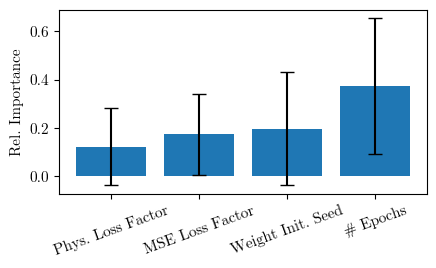

In [ ]:
(fig, ax), df = plot_sensitivity_with_error_bars(X, y, dimension_labels=dimension_labels, bootstrap_fac=0.5)
display(df)
plt.tight_layout()
plt.show()

In [172]:
import tqdm
from scipy import stats

load_skip = 10

ret_x = np.load(processed_expdata_dir / "x_ret_samples.npy")[::load_skip]
y_full = np.load(processed_expdata_dir / "y_ret_samples.npy")[:, ::load_skip]

means = np.empty((X.shape[1], y_full.shape[1]))
stds = np.empty((X.shape[1], y_full.shape[1]))

per_dim_vals = [list() for _ in range(X.shape[1])]

for i in tqdm.trange(y_full.shape[1]):
    bootstrap_coefficients = coefficient_stability(X, y_full[:, i], bootstrap_fac=0.5)
    for dim in range(X.shape[1]):
        per_dim_vals[dim].extend(bootstrap_coefficients[dim, :])
    means[:, i] = np.mean(bootstrap_coefficients, axis=1)
    stds[:, i] = np.std(bootstrap_coefficients, axis=1)

per_dim_vals = np.array(per_dim_vals)
per_dim_vals.shape

100%|██████████| 51/51 [00:06<00:00,  8.10it/s]


(4, 2550)

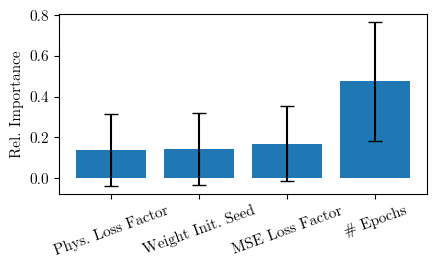

             Weight Init. Seed: 0.14, 0.18
             Phys. Loss Factor: 0.14, 0.18
               MSE Loss Factor: 0.17, 0.18
                      # Epochs: 0.48, 0.29


In [186]:
fig, ax = plt.subplots(figsize=(1.5*plotting.FIGURE_WIDTH, 1.5*plotting.FIGURE_HEIGHT))
bar_plot(np.mean(per_dim_vals, axis=1), np.std(per_dim_vals, axis=1), np.array(dimension_labels), ax)
plt.tight_layout()
plotting.savefig(fig, "../paper/figs/sensitivity_per_dimension")
plt.show()
for k, mean, std in zip(dimension_labels, np.mean(per_dim_vals, axis=1), np.std(per_dim_vals, axis=1)):
    print(f"{k:>30}: {mean:.2f}, {std:.2f}")

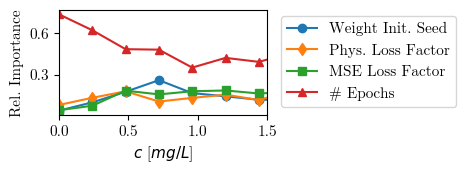

In [179]:
fig, ax = plt.subplots(figsize=(plotting.FIGURE_WIDTH, plotting.FIGURE_HEIGHT))

skip=6
PI_percent = 30
q1 = (1 - PI_percent / 100) / 2
q2 = (1 + PI_percent / 100) / 2

for dim in range(X.shape[1]):
    distr = stats.norm(loc=means[dim, ::skip], scale=stds[dim, ::skip])
    # 90% Gaussian
    ax.plot(ret_x[::skip], means[dim, ::skip], color=f"C{dim}", label=dimension_labels[dim], marker="ods^"[dim])
    # ax.fill_between(ret_x[::skip], distr.ppf(q1), distr.ppf(q2), alpha=0.3, color=f"C{dim}")

ax.set_xlim(0, 1.5)
plotting.set_retardation_axes_stuff(ax, set_xlabel=True, set_ylabel=True)
ax.set_ylabel("Rel. Importance")

fig.legend(
    *ax.get_legend_handles_labels(),
    loc="upper center",
    ncol=1,
    # bbox_to_anchor=(0.54, 1.3),
    # bbox_to_anchor=(0.54, 0.06),
    bbox_to_anchor=(1.25, 0.92),
)

plt.tight_layout()
plotting.savefig(fig, "../paper/figs/sensitivity")
plt.show()

In [174]:
# _, df = plot_sensitivity_with_error_bars(X, y, dimension_labels=dimension_labels, bootstrap_fac=0.5, hyperplane=True)
# display(df)